In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("toy_retis.nc", mode="r")
print len(storage.sample)

265


In [2]:
print len(storage.sampleset)
print len(storage.sample)

201
265


In [3]:
retis = storage.transition.load(0)
print retis

In [4]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [5]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 8.58 s, sys: 224 ms, total: 8.8 s
Wall time: 8.71 s


In [6]:
retis.histograms

{'max_lambda': {<openpathsampling.ensemble.SequentialEnsemble at 0x110a3ae10>: <openpathsampling.analysis.histogram.Histogram at 0x118fd8a90>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x118e90ad0>: <openpathsampling.analysis.histogram.Histogram at 0x11937a490>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x118eb5e10>: <openpathsampling.analysis.histogram.Histogram at 0x119648090>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x118ec5210>: <openpathsampling.analysis.histogram.Histogram at 0x119891090>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x118ec5410>: <openpathsampling.analysis.histogram.Histogram at 0x1194e5790>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x118ec5ed0>: <openpathsampling.analysis.histogram.Histogram at 0x1196e9110>},
 'pathlength': {<openpathsampling.ensemble.SequentialEnsemble at 0x110a3ae10>: <openpathsampling.analysis.histogram.Histogram at 0x118fd8890>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x118e90ad0>: <op

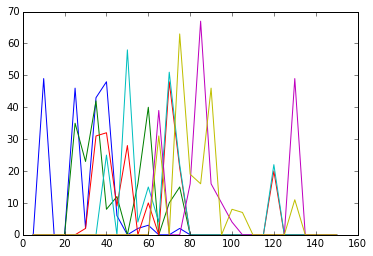

In [7]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist())

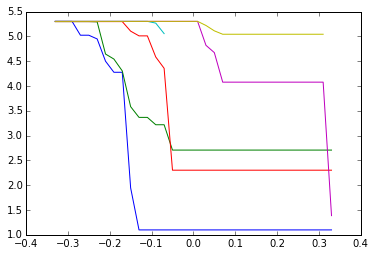

In [8]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), np.log(myhist.reverse_cumulative(None)))

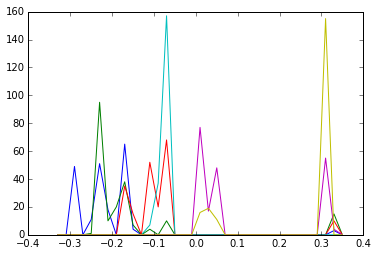

In [9]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

In [10]:
import openpathsampling.toy_dynamics as toys
pes = (toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) + 
       toys.toy_pes.Gaussian(2.0, [1.0, 4.0], [0.0,1.0]) + 
       toys.toy_pes.Gaussian(2.0, [25.0, 1.0], [0.0, -1.0])
      )
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(pes)

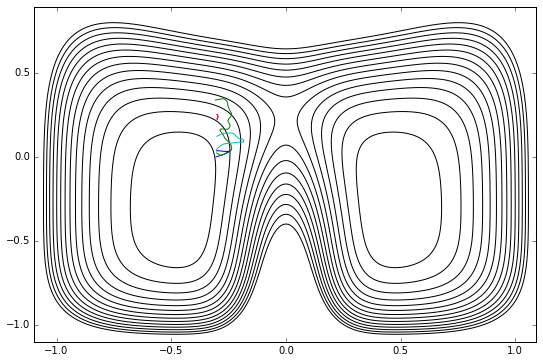

In [11]:
ens0_traj = [s.trajectory for s in storage.sample if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,10)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [12]:
from openpathsampling.analysis.histogram import histograms_to_pandas_dataframe
df = histograms_to_pandas_dataframe(retis.histograms['max_lambda'].values(), fcn="reverse_cumulative").sort(axis=1)
df

,max_lambda A->B I'face 0,max_lambda A->B I'face 1,max_lambda A->B I'face 2,max_lambda A->B I'face 3,max_lambda A->B I'face 4,max_lambda A->B I'face 5
-0.33,1.000000,1.000,1.000,1.000000,1.000000,1.000000
-0.31,1.000000,1.000,1.000,1.000000,1.000000,1.000000
-0.29,1.000000,1.000,1.000,1.000000,1.000000,1.000000
-0.27,0.756219,1.000,1.000,1.000000,1.000000,1.000000
-0.25,0.756219,1.000,1.000,1.000000,1.000000,1.000000
-0.23,0.701493,0.995,1.000,1.000000,1.000000,1.000000
-0.21,0.447761,0.520,1.000,1.000000,1.000000,1.000000
-0.19,0.358209,0.470,1.000,1.000000,1.000000,1.000000
-0.17,0.358209,0.370,1.000,1.000000,1.000000,1.000000
-0.15,0.034826,0.180,0.825,1.000000,1.000000,1.000000


In [13]:
# TODO: replace this with code from the TIS analysis that does it all automatically
from openpathsampling.analysis.wham import WHAM
wham = WHAM(cutoff=0.05)
wham.load_from_dataframe(df)
wham.clean_leading_ones()
wham_hist = wham.wham_bam_histogram()

ValueError: math domain error

In [ ]:
wham_hist_list = [ (k, wham_hist[k]) for k in sorted(wham_hist.keys()) ]
plt.plot(list(zip(*wham_hist_list)[0]), list(zip(*wham_hist_list)[1]))

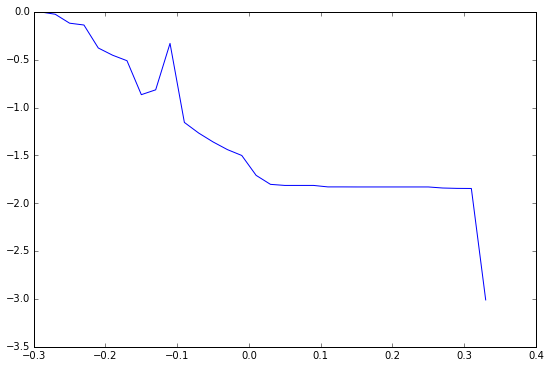

In [15]:
plt.plot(list(zip(*wham_hist_list)[0]), np.log(list(zip(*wham_hist_list)[1])))